In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import numpy as np
from math import floor
import torch.optim as optim
from matplotlib import pyplot as plt
import sobol_seq
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF


In [2]:
#A subclass loader. It inherits from torchvision.datsets.CIFAR10 and loads only the required classes. 
#SOURCE: stackoverflow

class SubLoader(torchvision.datasets.CIFAR10):
    def __init__(self, *args, exclude_list=[], **kwargs):
        super(SubLoader, self).__init__(*args, **kwargs)

        if exclude_list == []:
            return

        if self.train:
            labels = np.array(self.targets)
            exclude = np.array(exclude_list).reshape(1, -1)
            mask = ~(labels.reshape(-1, 1) == exclude).any(axis=1)

            self.data = self.data[mask]
            self.targets = labels[mask].tolist()
        else:
            labels = np.array(self.targets)
            exclude = np.array(exclude_list).reshape(1, -1)
            mask = ~(labels.reshape(-1, 1) == exclude).any(axis=1)

            self.data = self.data[mask]
            self.targets = labels[mask].tolist()


In [9]:
#To Load 5 classes. Sets up train and test dataloader
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = SubLoader(exclude_list=[i for i in range(5,10)],root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,shuffle=True, num_workers=2)
testset = SubLoader(exclude_list=[i for i in range(5,10)],root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
class CNN(nn.Module):
    def __init__(self,config):
        super(CNN, self).__init__()
        print("Sampling: {}".format(config))
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,config[0],5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(config[0], config[1], 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(5*5*config[1], 50)
        self.fc2 = nn.Linear(50, 5)
        self.epoch = 0
        self.config = config
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 5*5*int(self.config[1]))
        out = F.relu(self.fc1(out))
        out = F.softmax(self.fc2(out),dim=1)
        return out
    
def run_config(config):
    cnn = CNN(config)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(cnn.parameters(), lr=config[2], momentum=0.9)
    epochs =5
    for epoch in range(epochs):
        for ibatch,batch in enumerate(trainloader):
            ip,labels = batch
            optimizer.zero_grad()
            pred = cnn(ip)
            disc_loss = criterion(pred, labels)
            disc_loss.backward()
            optimizer.step()
        cnn.epoch +=1
        #Test accuracy:
        correct = 0
        total = 0
        
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = correct/total*100
    print("Test accuracy is: {}% ".format(test_acc))
        
        
    return test_acc/100


In [43]:
def query(lr_low, lr_high,hidden1_low, hidden1_high, hidden2_low, hidden2_high,sobol):
    
    arm_lr = lr_low + sobol[0]*(lr_high-lr_low)
    arm_nh1 = hidden1_low +floor(sobol[1]*(hidden1_high - hidden1_low))
    arm_nh2 = hidden2_low + floor(sobol[2]*(hidden2_high - hidden2_low))
    
    return [arm_nh1,arm_nh2,arm_lr]  

def binarization(prob):
    
    if np.random.random() < prob:
        return 1
    else:
        return 0

In [44]:
#Define ranges, exploitation, exploration and pool space
t = 0
Budget = 100
lr_low = 1e-6
lr_high = 1e-2
nh1_low = 2
nh1_high = 10
nh2_low = 5
nh2_high = 20

exploitation_count = 2
exploration_count = 3
pool_count = 1200
seq = sobol_seq.i4_sobol_generate(3,pool_count)
pool = [query(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,sobol) for sobol in seq]

arms_query = []
arms_query_acc = []
beta = 0.9

narms = 0
wins_arm = []
lose_arm = []

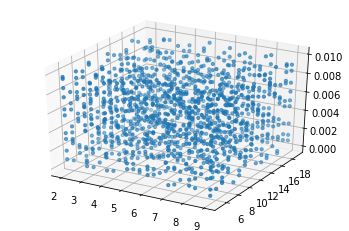

In [45]:
#Visualize pool space

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pool_array = np.array([np.array(xi) for xi in pool])
ax.scatter(pool_array[:,0].reshape(-1), pool_array[:,1].reshape(-1), pool_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)

In [ ]:
#Start sampling

while t<Budget:
    print("Exploring")
    for i in range(exploration_count):
        query_index = floor(np.random.random()*(len(pool)-1))
        popped = pool.pop(query_index)
        arms_query.append(popped)
        wins_arm.append(0)
        lose_arm.append(0)
        arms_query_acc.append(0)
        acc = run_config(arms_query[-1])
        arms_query_acc[-1] = acc
        
        binary = binarization(acc)
        wins_arm[-1] += binary
        lose_arm[-1] += 1-binary
        narms+=1
    
    print("Exploiting")
    reward_sample = [np.random.beta(wins_arm[i]+1,lose_arm[i]+1) for i in range(narms)]    
    I_1 = sorted(range(len(reward_sample)), key=lambda i: reward_sample[i])[-exploitation_count:]
    if np.random.random() > beta:
        
        reward_sample = [np.random.beta(wins_arm[i]+1,lose_arm[i]+1) for i in range(narms)]    
        I_1 = sorted(range(len(reward_sample)), key=lambda i: reward_sample[i])[-exploitation_count:]
    
    for arm in I_1:
        acc = run_config(arms_query[arm])
        binary = binarization(acc)
        wins_arm[arm] += binary
        lose_arm[arm] += 1-binary
        arms_query_acc[arm] = (arms_query_acc[arm]*(wins_arm[arm]+lose_arm[arm] - 1) + acc) / (wins_arm[arm]+lose_arm[arm]) 

    t+=1
        
        


Exploring
Sampling: [5, 13, 0.00798360009765625]
Test accuracy is: 57.699999999999996% 
Sampling: [4, 10, 0.00949223828125]


In [22]:
np.save("./arms_query1_cnn",arms_query)
np.save("./arms_query_acc1_cnn",arms_query_acc)
np.save("./pool1_cnn",pool)

In [36]:
def normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,inp):
    inp[:,0] = (inp[:,0] - nh1_low)/(nh1_high - nh1_low)
    inp[:,1] = (inp[:,1] - nh2_high)/(nh2_high - nh2_low)
    inp[:,2] = (inp[:,2] - lr_low)/(lr_high - lr_low)
    return inp

# Accuracy Predictor
#Train
k = 1.1 ** 2 * RBF(length_scale=0.1) #Check parameters
X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(arms_query).reshape(-1,3))
y = np.array(arms_query_acc).reshape(-1,1)
test_X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(pool).reshape(-1,3))

gp = GPR(kernel=k, alpha=0.001, optimizer='fmin_l_bfgs_b',normalize_y=False)
gp.fit(X,y)
y_pred, y_std = gp.predict(test_X, return_std=True)
print("Best query arm is {} with accuracy of : {} ".format(arms_query[np.argmax(arms_query_acc)],arms_query_acc[np.argmax(arms_query_acc)]))

print("Best pool arm is {} with accuracy of : {} ".format(pool[np.argmax(y_pred)],y_pred[np.argmax(y_pred),0]))
print(y_pred[:5])

Best query arm is [8, 19, 0.00872571337890625] with accuracy of : 0.6126 
Best pool arm is [9, 18, 0.00941412109375] with accuracy of : 0.5938622442976644 
[[0.56392168]
 [0.41973183]
 [0.47801257]
 [0.56741431]
 [0.52039895]]


In [37]:
#run_config(arms_query[np.argmax(arms_query_acc)])
run_config(pool[np.argmax(y_pred)])

Sampling: [9, 18, 0.00941412109375]
Test accuracy is: 58.3% 


0.583

In [28]:

y_actual = []
for i in pool[:5]:
    y_actual.append(run_config(i))
print(y_actual)
    

Sampling: [4, 16, 0.007500250000000001]
Test accuracy is: 56.48% 
Sampling: [8, 8, 0.0025007500000000004]
Test accuracy is: 42.68% 
Sampling: [5, 14, 0.0037506250000000005]
Test accuracy is: 52.339999999999996% 
Sampling: [9, 6, 0.008750125]
Test accuracy is: 56.00000000000001% 
Sampling: [3, 10, 0.006250375000000001]
Test accuracy is: 52.7% 
[0.5648, 0.4268, 0.5234, 0.56, 0.527]


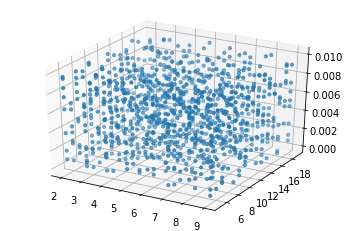

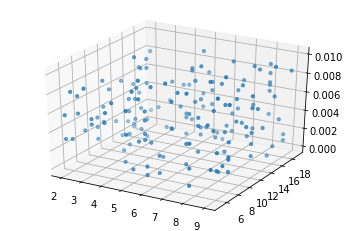

In [35]:
#Visualize

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pool_array = np.array([np.array(xi) for xi in pool])
ax.scatter(pool_array[:,0].reshape(-1), pool_array[:,1].reshape(-1),pool_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)        
        

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
arms_query_array = np.array([np.array(xi) for xi in arms_query])
ax.scatter(arms_query_array[:,0].reshape(-1), arms_query_array[:,1].reshape(-1),  arms_query_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)

In [48]:
#Define ranges, exploitation, exploration and pool space
t = 0
Budget = 100
lr_low = 1e-6
lr_high = 1e-2
nh1_low = 2
nh1_high = 10
nh2_low = 5
nh2_high = 20

exploitation_count = 2
exploration_count = 3
pool_count = 1200
seq = sobol_seq.i4_sobol_generate(3,pool_count)
pool = [query(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,sobol) for sobol in seq]

arms_query = []
arms_query_acc = []
beta = 0.9

narms = 0
wins_arm = []
lose_arm = []


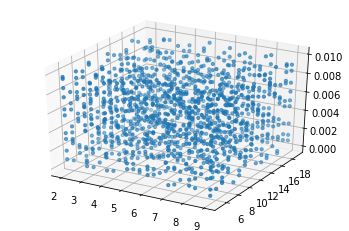

In [49]:
#Visualize pool space

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pool_array = np.array([np.array(xi) for xi in pool])
ax.scatter(pool_array[:,0].reshape(-1), pool_array[:,1].reshape(-1), pool_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)

In [50]:
      
def variance_pred(X,y,test_X):
    k = 1.1 ** 2 * RBF(length_scale=0.1) #Check parameters
    gp = GPR(kernel=k, alpha=0.001, optimizer='fmin_l_bfgs_b',normalize_y=False)
    gp.fit(X,y)
    y_pred, y_std = gp.predict(test_X, return_std=True)
    return y_std

In [ ]:
#With Predictor in the loop

while t<Budget:
    print("Exploring")
    if t== 0 :
        for i in range(exploration_count):
            query_index = floor(np.random.random()*(len(pool)-1))
            popped = pool.pop(query_index)
            arms_query.append(popped)
            wins_arm.append(0)
            lose_arm.append(0)
            arms_query_acc.append(0)
            acc = run_config(arms_query[-1])
            arms_query_acc[-1] = acc

            binary = binarization(acc)
            wins_arm[-1] += binary
            lose_arm[-1] += 1-binary
            narms+=1
    else:
        X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(arms_query).reshape(-1,3))
        y = np.array(arms_query_acc).reshape(-1,1)
        test_X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(pool).reshape(-1,3))
        var = variance_pred(X,y,test_X)
        exp = sorted(range(len(var)), key=lambda i: var[i])[-exploration_count:]
        
        for arms in exp:
            popped = pool[arms]
            arms_query.append(popped)
            wins_arm.append(0)
            lose_arm.append(0)
            arms_query_acc.append(0)
            acc = run_config(arms_query[-1])
            arms_query_acc[-1] = acc
            binary = binarization(acc)
            wins_arm[-1] += binary
            lose_arm[-1] += 1-binary
            narms+=1
        for arms in exp:
            pool.pop(arms)
            
        
    
    print("Exploiting")
    reward_sample = [np.random.beta(wins_arm[i]+1,lose_arm[i]+1) for i in range(narms)]    
    I_1 = sorted(range(len(reward_sample)), key=lambda i: reward_sample[i])[-exploitation_count:]
    
    if np.random.random() > beta:
        
        reward_sample = [np.random.beta(wins_arm[i]+1,lose_arm[i]+1) for i in range(narms)]    
        I_1 = sorted(range(len(reward_sample)), key=lambda i: reward_sample[i])[-exploitation_count:]
    
    for arm in I_1:
        acc = run_config(arms_query[arm])
        binary = binarization(acc)
        wins_arm[arm] += binary
        lose_arm[arm] += 1-binary
        arms_query_acc[arm] = (arms_query_acc[arm]*(wins_arm[arm]+lose_arm[arm] - 1) + acc) / (wins_arm[arm]+lose_arm[arm]) 

    t+=1

        
    


Exploring
Sampling: [9, 12, 0.007431897460937501]
Test accuracy is: 56.66% 
Sampling: [2, 5, 0.0031745107421875004]
Test accuracy is: 43.46% 
Sampling: [4, 12, 0.006474961914062501]
Test accuracy is: 55.84% 
Exploiting
Sampling: [4, 12, 0.006474961914062501]
Test accuracy is: 54.400000000000006% 
Sampling: [9, 12, 0.007431897460937501]
Test accuracy is: 58.5% 
Exploring
Sampling: [8, 15, 0.0007577602539062501]
Test accuracy is: 20.0% 
Sampling: [9, 7, 0.0023201040039062502]
Test accuracy is: 41.48% 
Sampling: [7, 11, 0.00044529150390625006]
Test accuracy is: 25.240000000000002% 
Exploiting
Sampling: [2, 5, 0.0031745107421875004]
Test accuracy is: 24.14% 
Sampling: [8, 15, 0.0007577602539062501]
Test accuracy is: 31.680000000000003% 
Exploring
Sampling: [2, 19, 0.009121181640625]
Test accuracy is: 55.52% 
Sampling: [2, 19, 0.0013192275390625]
Test accuracy is: 30.020000000000003% 
Sampling: [2, 19, 0.0006649960937500001]
Test accuracy is: 32.24% 
Exploiting
Sampling: [9, 12, 0.007431897

Test accuracy is: 21.08% 
Exploiting
Sampling: [2, 5, 0.0095215322265625]
Test accuracy is: 49.6% 
Sampling: [6, 5, 0.005332498046875001]
Test accuracy is: 48.72% 
Exploring
Sampling: [6, 19, 0.005996494140625001]
Test accuracy is: 56.620000000000005% 
Sampling: [6, 19, 0.0041509755859375]
Test accuracy is: 50.3% 
Sampling: [5, 19, 0.006123434570312501]
Test accuracy is: 53.32% 
Exploiting
Sampling: [9, 5, 0.00020605761718750002]
Test accuracy is: 21.5% 
Sampling: [9, 19, 0.004600149414062501]
Test accuracy is: 54.67999999999999% 
Exploring
Sampling: [2, 19, 0.0088575361328125]
Test accuracy is: 55.120000000000005% 
Sampling: [7, 5, 0.0004111152343750001]
Test accuracy is: 20.0% 
Sampling: [2, 19, 0.0013192275390625]
Test accuracy is: 41.14% 
Exploiting
Sampling: [6, 5, 0.005332498046875001]
Test accuracy is: 51.080000000000005% 
Sampling: [2, 5, 0.0095215322265625]
Test accuracy is: 51.519999999999996% 
Exploring
Sampling: [9, 11, 0.00431209228515625]
Test accuracy is: 53.36% 
Samplin

In [ ]:
np.save("./arms_query2_cnn",arms_query)
np.save("./arms_query_acc2_cnn",arms_query_acc)
np.save("./pool2_cnn",pool)

In [ ]:
# Accuracy Predictor
#Train

k = 1.1 ** 2 * RBF(length_scale=0.1) #Check parameters
X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(arms_query).reshape(-1,3))
y = np.array(arms_query_acc).reshape(-1,1)
test_X = normalized(lr_low,lr_high,nh1_low,nh1_high,nh2_low,nh2_high,np.array(pool).reshape(-1,3))

gp = GPR(kernel=k, alpha=0.001, optimizer='fmin_l_bfgs_b',normalize_y=False)
gp.fit(X,y)
y_pred, y_std = gp.predict(test_X, return_std=True)
print("Best query arms is {} with accuracy of : {} ".format(arms_query[np.argmax(arms_query_acc)],arms_query_acc[np.argmax(arms_query_acc)]))

print("Best pool arms is {} with accuracy of : {} ".format(pool[np.argmax(y_pred)],y_pred[np.argmax(y_pred),0]))
print(y_pred[:20])

In [ ]:
#Visualize

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pool_array = np.array([np.array(xi) for xi in pool])
ax.scatter(pool_array[:,0].reshape(-1), pool_array[:,1].reshape(-1),pool_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)        
        

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
arms_query_array = np.array([np.array(xi) for xi in arms_query])
ax.scatter(arms_query_array[:,0].reshape(-1), arms_query_array[:,1].reshape(-1),  arms_query_array[:,2].reshape(-1), zdir='z', s=10, c=None, depthshade=True)